# Eploration of encoder for Image transformation

In [ ]:
import torch
import torchvision.models as models
import torch.nn as nn
import os
from torch import optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from tqdm import tqdm


## Autoencoder

### Autoencoder from pretrained Resnet

In [ ]:

# Load a pretrained CNN
pretrained_cnn = models.resnet18(pretrained=True)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 139MB/s]


In [ ]:
list(pretrained_cnn.children())[:-2]

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

In [ ]:

# Load a pretrained CNN
pretrained_cnn = models.resnet18(pretrained=True)

# Remove the fully connected layers (classifier)
features = list(pretrained_cnn.children())[:-2]  # Remove the last two layers

# Create the autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(*features)
        self.decoder = nn.Sequential(
            # Construct the decoder that mirrors the encoder architecture
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            # Add more layers as necessary...
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            # Final layer to reconstruct the original image size
            nn.ConvTranspose2d(128, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Initialize the autoencoder
autoencoder = Autoencoder()

# Now, you can further train this model on your specific dataset to adapt it
# Remember to set the required gradient properties and train it using your preferred optimizer and loss function.


### From Scratch

#### Load data

In [ ]:
# Connect git repo to access data
!git clone https://github.com/valentin-brekke/emotion_artistic_augmentation.git

Cloning into 'emotion_artistic_augmentation'...
remote: Enumerating objects: 40974, done.
remote: Counting objects: 100% (6915/6915), done.
remote: Compressing objects: 100% (6912/6912), done.
remote: Total 40974 (delta 2), reused 6915 (delta 2), pack-reused 34059
Receiving objects: 100% (40974/40974), 222.52 MiB | 43.78 MiB/s, done.
Resolving deltas: 100% (10/10), done.
Updating files: 100% (42795/42795), done.


In [ ]:
# Directory where the natural_images folder is located
data_dir = os.getcwd() + '/emotion_artistic_augmentation/data/natural_images'

# Transformations to be applied on images
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to 256x256
    transforms.ToTensor(),  # Convert images to PyTorch tensors
])

# Load the dataset
dataset = datasets.ImageFolder(root=data_dir, transform=transform)


In [ ]:
dataset

Dataset ImageFolder
    Number of datapoints: 6899
    Root location: /content/emotion_artistic_augmentation/data/natural_images
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

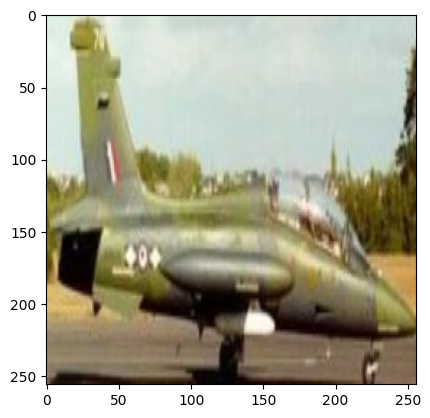

In [ ]:
plt.imshow(dataset[0][0].permute(1, 2, 0))

In [ ]:
# Calculate split sizes
total_count = len(dataset)
train_count = int(0.8 * total_count)
test_count = total_count - train_count

# Split dataset
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_count, test_count])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

#### Model easy

In [ ]:

class ConvAutoencoder_simple(nn.Module):
    def __init__(self, return_encoded):
        self.return_encoded = return_encoded
        super(ConvAutoencoder_simple, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 3, 3, stride=1, padding='same'),
            nn.ReLU(),
            )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(3, 3, 3, stride=1, padding='same'),
            nn.ReLU(),
            )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        if self.return_encoded:
          return encoded, decoded
        else:
          return decoded


In [ ]:

class ConvAutoencoder_v2(nn.Module):
    def __init__(self, return_encoded):
        self.return_encoded = return_encoded
        super(ConvAutoencoder_v2, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=1, padding='same'),   # Output: 16x256x256
            nn.ReLU(),
            nn.MaxPool2d(2, 2),     # 16x128x128
            )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 3, 3, padding=1),  # Output: 3 x 128 x 128
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),           # Output: 3 x 256 x 256
            )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        if self.return_encoded:
          return encoded, decoded
        else:
          return decoded


In [ ]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model, loss function, and optimizer
model = ConvAutoencoder_v2(return_encoded=False).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    loop = tqdm(train_loader, leave=True)
    for data in loop:
        img, _ = data
        img = img.to(device)
        # Forward pass
        output = model(img)
        loss = criterion(output, img)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update the progress bar with the latest loss
        loop.set_description(f'Epoch [{epoch+1}/{num_epochs}]')
        loop.set_postfix(loss=loss.item())
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')



Epoch [1/10]: 100%|██████████| 87/87 [00:24<00:00,  3.58it/s, loss=0.00639]


Epoch [1/10], Loss: 0.0064


Epoch [2/10]: 100%|██████████| 87/87 [00:23<00:00,  3.74it/s, loss=0.00348]


Epoch [2/10], Loss: 0.0035


Epoch [3/10]: 100%|██████████| 87/87 [00:20<00:00,  4.15it/s, loss=0.00428]


Epoch [3/10], Loss: 0.0043


Epoch [4/10]: 100%|██████████| 87/87 [00:21<00:00,  3.99it/s, loss=0.00228]


Epoch [4/10], Loss: 0.0023


Epoch [5/10]: 100%|██████████| 87/87 [00:21<00:00,  4.01it/s, loss=0.00144]


Epoch [5/10], Loss: 0.0014


Epoch [6/10]: 100%|██████████| 87/87 [00:21<00:00,  3.98it/s, loss=0.00153]


Epoch [6/10], Loss: 0.0015


Epoch [7/10]: 100%|██████████| 87/87 [00:21<00:00,  4.03it/s, loss=0.000949]


Epoch [7/10], Loss: 0.0009


Epoch [8/10]: 100%|██████████| 87/87 [00:21<00:00,  4.11it/s, loss=0.00127]


Epoch [8/10], Loss: 0.0013


Epoch [9/10]: 100%|██████████| 87/87 [00:21<00:00,  3.97it/s, loss=0.000823]


Epoch [9/10], Loss: 0.0008


Epoch [10/10]: 100%|██████████| 87/87 [00:22<00:00,  3.82it/s, loss=0.00128]

Epoch [10/10], Loss: 0.0013


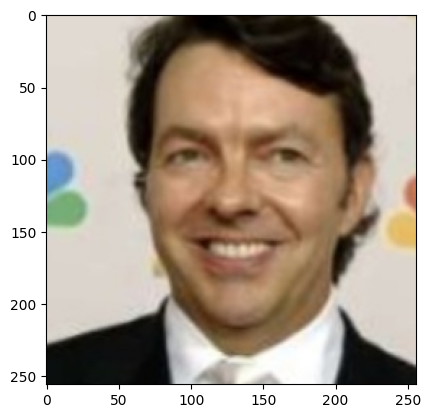

In [ ]:
plt.imshow(test_dataset[0][0].permute(1, 2, 0))

In [ ]:
out = model(train_dataset[0][0].to(device))

NameError: name 'model' is not defined

In [ ]:
out.shape

torch.Size([3, 128, 256])

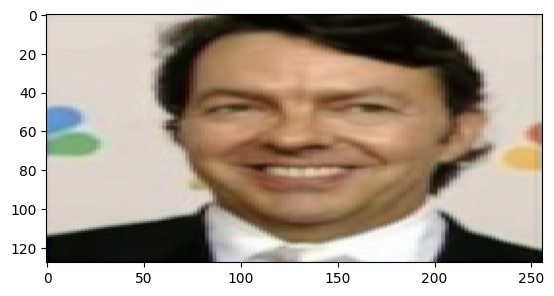

In [ ]:
plt.imshow(out.cpu().detach().permute(1, 2, 0))

In [ ]:
criterion(train_dataset[0][0].to(device), out)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([3, 128, 256])) that is different to the input size (torch.Size([3, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (256) must match the size of tensor b (128) at non-singleton dimension 1

#### Model deeper

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=1, padding=1),   # Output: 16x256x256
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                        # Output: 16x128x128
            nn.Conv2d(16, 32, 3, stride=1, padding=1),  # Output: 32x128x128
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                        # Output: 32x64x64
            nn.Conv2d(32, 64, 3, stride=1, padding=1),  # Output: 64x64x64
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                        # Output: 64x32x32
            nn.Conv2d(64, 128, 3, stride=1, padding=1), # Output: 128x32x32
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                        # Output: 128x16x16
            nn.Conv2d(128, 256, 3, stride=1, padding=1),# Output: 256x16x16
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                        # Output: 256x8x8
            nn.Conv2d(256, 100, 3, stride=1, padding=0),# Output: 100x6x6
            nn.ReLU()
        )
        # Flatten and Linear layer to reduce to 100 features
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(100*6*6, 100)

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(100, 256, 3, stride=1, padding=0),  # Output: 256x8x8
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),           # Output: 256x16x16
            nn.ConvTranspose2d(256, 128, 3, stride=1, padding=1),  # Output: 128x16x16
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),           # Output: 128x32x32
            nn.ConvTranspose2d(128, 64, 3, stride=1, padding=1),   # Output: 64x32x32
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),           # Output: 64x64x64
            nn.ConvTranspose2d(64, 32, 3, stride=1, padding=1),    # Output: 32x64x64
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),           # Output: 32x128x128
            nn.ConvTranspose2d(32, 16, 3, stride=1, padding=1),    # Output: 16x128x128
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),           # Output: 16x256x256
            nn.ConvTranspose2d(16, 3, 3, stride=1, padding=1),     # Output: 3x256x256
            nn.ReLU()
        )

        # # Decoder
        # self.decoder = nn.Sequential(
        #     nn.ConvTranspose2d(100, 256, 3, stride=2, padding=0),  # Output: 256x5x5
        #     nn.ReLU(),
        #     nn.Upsample(scale_factor=2, mode='nearest'),           # Output: 256x10x10
        #     nn.ConvTranspose2d(256, 128, 5, stride=2, padding=1, output_padding=1),  # Output: 128x20x20
        #     nn.ReLU(),
        #     nn.Upsample(scale_factor=2, mode='nearest'),           # Output: 128x40x40
        #     nn.ConvTranspose2d(128, 64, 5, stride=2, padding=1, output_padding=1),   # Output: 64x82x82
        #     nn.ReLU(),
        #     nn.Upsample(scale_factor=3, mode='nearest'),           # Output: 64x246x246
        #     nn.ConvTranspose2d(64, 32, 5, stride=1, padding=1),    # Output: 32x250x250
        #     nn.ReLU(),
        #     nn.Upsample(scale_factor=2, mode='nearest'),           # Output: 32x500x500 (Too large, adjust)
        #     nn.ConvTranspose2d(32, 16, 5, stride=1, padding=2),    # Output: 16x504x504 (Adjust)
        #     nn.ReLU(),
        #     nn.ConvTranspose2d(16, 3, 6, stride=1, padding=3),     # Output: 3x256x256
        #     nn.ReLU()
        # )

    def forward(self, x):
        x = self.encoder(x)
        # x = self.flatten(x)
        # x = self.fc(x)  # Reduce to 100 features
        # x = x.view(-1, 100, 1, 1)  # Reshape flat features back to (N, C, H, W)
        x = self.decoder(x)
        return x

In [ ]:
# Initialize the model, loss function, and optimizer
model = AutoEncoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    loop = tqdm(train_loader, leave=True)
    for data in loop:
        img, _ = data
        img = img.to(device)
        # Forward pass
        output = model(img)
        loss = criterion(output, img)


        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update the progress bar with the latest loss
        loop.set_description(f'Epoch [{epoch+1}/{num_epochs}]')
        loop.set_postfix(loss=loss.item())
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')



Epoch [1/10]: 100%|██████████| 87/87 [00:32<00:00,  2.68it/s, loss=0.0813]


Epoch [1/10], Loss: 0.0813


Epoch [2/10]: 100%|██████████| 87/87 [00:30<00:00,  2.81it/s, loss=0.0923]


Epoch [2/10], Loss: 0.0923


Epoch [3/10]: 100%|██████████| 87/87 [00:33<00:00,  2.59it/s, loss=0.106]


Epoch [3/10], Loss: 0.1057


Epoch [4/10]: 100%|██████████| 87/87 [00:31<00:00,  2.78it/s, loss=0.0916]


Epoch [4/10], Loss: 0.0916


Epoch [5/10]: 100%|██████████| 87/87 [00:31<00:00,  2.78it/s, loss=0.0744]


Epoch [5/10], Loss: 0.0744


Epoch [6/10]: 100%|██████████| 87/87 [00:31<00:00,  2.75it/s, loss=0.0752]


Epoch [6/10], Loss: 0.0752


Epoch [7/10]: 100%|██████████| 87/87 [00:31<00:00,  2.80it/s, loss=0.0951]


Epoch [7/10], Loss: 0.0951


Epoch [8/10]: 100%|██████████| 87/87 [00:31<00:00,  2.78it/s, loss=0.0795]


Epoch [8/10], Loss: 0.0795


Epoch [9/10]: 100%|██████████| 87/87 [00:31<00:00,  2.75it/s, loss=0.0838]


Epoch [9/10], Loss: 0.0838


Epoch [10/10]: 100%|██████████| 87/87 [00:30<00:00,  2.81it/s, loss=0.0911]

Epoch [10/10], Loss: 0.0911


In [ ]:
from torchsummary import summary
summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]             448
              ReLU-2         [-1, 16, 256, 256]               0
         MaxPool2d-3         [-1, 16, 128, 128]               0
            Conv2d-4         [-1, 32, 128, 128]           4,640
              ReLU-5         [-1, 32, 128, 128]               0
         MaxPool2d-6           [-1, 32, 64, 64]               0
            Conv2d-7           [-1, 64, 64, 64]          18,496
              ReLU-8           [-1, 64, 64, 64]               0
         MaxPool2d-9           [-1, 64, 32, 32]               0
           Conv2d-10          [-1, 128, 32, 32]          73,856
             ReLU-11          [-1, 128, 32, 32]               0
        MaxPool2d-12          [-1, 128, 16, 16]               0
           Conv2d-13          [-1, 256, 16, 16]         295,168
             ReLU-14          [-1, 256,

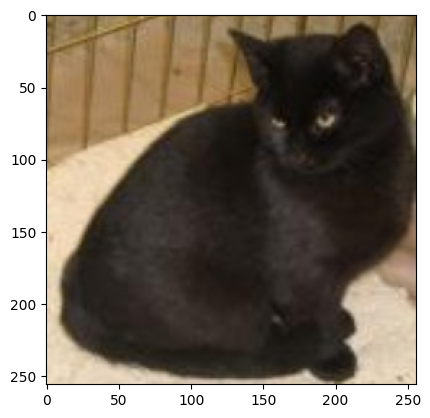

In [ ]:
plt.imshow(train_dataset[0][0].permute(1, 2, 0))

In [ ]:
out = model(train_dataset[0][0].to(device).unsqueeze(0))

In [ ]:
train_dataset[0][0].to(device).shape

torch.Size([3, 256, 256])

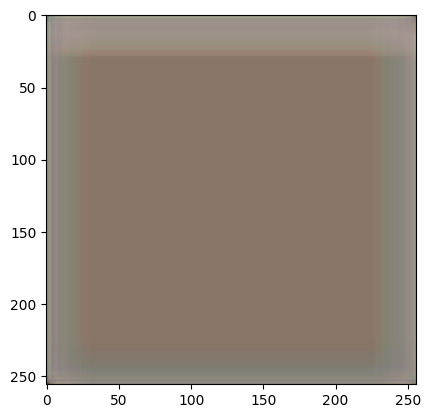

In [ ]:
plt.imshow(out.squeeze().cpu().detach().permute(1, 2, 0))

In [ ]:
criterion(train_dataset[0][0].to(device), out)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([3, 8, 256])) that is different to the input size (torch.Size([3, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (256) must match the size of tensor b (8) at non-singleton dimension 1